# MarginGAN

The implementation of the NIPS 2019 paper "MarginGAN: Adversarial Training in Semi-Supervised Learning".

#### Link: https://papers.nips.cc/paper/9231-margingan-adversarial-training-in-semi-supervised-learning7

Can Ufuk Ertenli - 2030666 \& Zeynep Sonat Baltacı - 2098788

We start with a brief overview of MarginGAN.

As it is stated in the paper:
“The margin of a single data point is defined to be the distance from that data point to a decision boundary, which can be used to bound the generalization error of the classifier.”
In semi-supervised learning, if the classifier chooses to believe the wrong pseudo labels (predicted labels for the unlabeled data), the margin between the decision boundaries decreases, which hurts the generalization accuracy. Therefore, large-margin classifiers should ignore those wrong pseudo labels for achieving higher accuracy. MarginGAN is a semi-supervised learning model which utilizes a standard GAN architecture to improve the performance of a classifier by increasing the margin of real examples and decreasing the margin of generated examples in parallel. 

In addition to a generator G and a discriminator D there is a classifier C in MarginGAN. D has an objective to classify real and fake images, regardless of whether it is labeled or unlabeled. C has the same objective as ordinary multi-class classifiers for labeled samples.  For unlabeled samples, the goal of the classifier is to increase the margin of these data points. However, since unlabeled samples has no known “true” label, one-hot encoded pseudo label concept is leveraged, which stores a 1 for the class with the maximum predicted probability of current C and 0 otherwise. As in the standard GAN, G tries to fool D by generating realistic examples. On the other hand, because C increases the margin of real examples and decreases the margin of fake examples, G generates data points having large margin to fool C. Therefore, in order to fool both D and C, G tries to generate realistic and large-margin examples simultaneously such that the generated fake data points cannot easily be separated from real examples. 

The paper uses 4 different number of labeled examples, $100$, $600$, $1000$ and $3000$ to conduct the experiments. For the generator and the discriminator, MarginGAN utilizes the well-known architecture of InfoGAN. To predict the pseudo labels, classifier architecture of MarginGAN is pre-trained for all label sizes to be used within the training of the corresponding architecture. The pretraining is performed until the classifier reached the accuracy levels of 80%, 93%, 95% and 97%, respectively for each label size. Later, it is fine-tuned with the generator and the discriminator. The generated examples of the final model are near the decision boundary, that is their class labels cannot be determined with ease, which satisfies the aim of the architecture.


We perform our experiments using Python 3.7.6 and PyTorch 1.5.0. For the full details of the setup an environment.yml file has been provided. We provide both CPU and GPU support to execute the code. Our hyperparameters are set as the default arguments in our code. Here is a complete list of all hyperparameters: 
1. Learning Rate of Classifier: $0.01$
2. Learning Rate of Generator: $0.0002$
3. Learning Rate of Discriminator: $0.0002$
4. Momentum for SGD Optimizer: $0.8$
5. $\beta_1$ for Adam Optimizer: $0.5$
6. $\beta_2$ for Adam Optimizer: $0.999$
7. Batch Size: $50$
8. Torch Seed: $0$

Our code is presented below.

In [1]:
# Import necessary libraries
import torch.optim as optim
import torchvision.transforms as transforms
import argparse
import warnings
from itertools import cycle
from marginGAN import *
from utils import *
from dataset import *
from model_paths import *

In [2]:
# Set hyperparameters
batch_size = 50
seed = 0
num_epochs = 50
lrC = 0.01
lrG = 0.0002
lrD = 0.0002
beta_1 = 0.5
beta_2 = 0.999
momentum = 0.8
log_every = 1000
job_id = 1
device = "cuda:0"

In [3]:
# Select GPU/CPU
if torch.cuda.is_available():
    device = torch.device(device)
else:
    device = torch.device("cpu")

In [4]:
# Ignore warnings to avoid clutter when using different PyTorch versions
warnings.filterwarnings("ignore")

# Provide manual seed for reproducibility
torch.manual_seed(seed)

# Create save directories
create_dirs(job_id)

In [5]:
# Create dictionary for storing parameters
params = {'job_id': job_id,
          'batch_size': batch_size,
          'seed': seed,
          'num_epochs': num_epochs,
          'lrC': lrC,
          'lrG': lrG,
          'lrD': lrD,
          'beta_1': beta_1,
          'beta_2': beta_2,
          'momentum': momentum,
}

# Save the hyperparameters
param_log(params)

In [6]:
# Load the datasets
# Reserve 10,000 samples for validation
dataset = torchvision.datasets.MNIST("./data",train=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]),target_transform=None,download=True)
trainset, valset = torch.utils.data.random_split(dataset, [50000, 10000])
testset = torchvision.datasets.MNIST("./data",train=False,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))]),target_transform=None,download=True)

valloader = torch.utils.data.DataLoader(
                                    dataset=valset,
                                    batch_size=batch_size,
                                    shuffle=False)

testloader = torch.utils.data.DataLoader(
                                    dataset=testset,
                                    batch_size=batch_size,
                                    shuffle=False)

In [7]:
# Use a fixed noise for the reproducibility of generated samples
fixed_noise = torch.rand(batch_size,62).to(device)

In [8]:
# Set the number of labeled examples
label_sizes = [100,600,1000,3000]

In [9]:
# Train and save the model
# Perform training on 4 different number of labeled examples 
for label_size in label_sizes:
    # Divide the dataset into labeled and unlabeled samples
    labeled_set, unlabeled_set = divide_dataset(trainset, label_size)

    labeled_loader = torch.utils.data.DataLoader(dataset=labeled_set,batch_size=batch_size,shuffle=True)
    unlabeled_loader = torch.utils.data.DataLoader(dataset=unlabeled_set,batch_size=batch_size,shuffle=True)

    # Load the model
    marginGAN = MarginGAN(label_size=label_size,
                          batch_size=batch_size,
                          device=device,
                          lrs=[lrD, lrG, lrC],
                          beta_1=beta_1,
                          beta_2=beta_2,
                          momentum=momentum,
                          pretrained="pretrained_classifiers/pre_cls_label_model_"+str(label_size)+".pt")

    # Cycle over the same labeled examples during training
    zipped_loader = zip(cycle(labeled_loader), unlabeled_loader)

    best_correct = 0

    for epoch in range(num_epochs):
        # Train for one epoch
        marginGAN.train(zipped_loader,epoch,log_every)
        # Reinitialize the iterator
        zipped_loader = zip(cycle(labeled_loader), unlabeled_loader)

        if (epoch+1) % 1 == 0:
            # Evaluate the model on the validation set
            correct_guesses = marginGAN.eval(valloader)

            if correct_guesses > best_correct:
                best_correct = correct_guesses
                # Save the model
                marginGAN.save(epoch,fixed_noise,job_id)
                # Log the accuracy
                print('[',epoch+1,']','Accuracy: %d %%' % (100 * correct_guesses / 10000), correct_guesses,"/", 10000)

In [11]:
# Load and test the model
print("-"*77)
for label_size in label_sizes:
    if label_size == 100 or label_size == 600:
        print("| Label Size: ", label_size, end = " ")
    else:
        print("| Label Size:", label_size, end = " ")
print("|")
print("-"*77)
for label_size in label_sizes:
    all_model_paths = model_paths()
    models = all_model_paths[str(label_size)]
    worst_err = 100
    best_err = 0
    acc_hist = []
    # Compute the average, best and worst error rates over 5 runs
    for i in range(5):
        marginGAN.load(models[i])
        correct = marginGAN.test(fixed_noise,testloader)
        acc_hist.append(correct)

    avg_err = (10000 - np.mean(acc_hist))/100
    worst_err = (10000 - min(acc_hist))/100
    best_err = (10000 - max(acc_hist))/100
    
    # Print the table
    if abs(avg_err - worst_err) > abs(avg_err - best_err):
        print("| %.2f" % (avg_err),u"\u00B1","%.2f" % (abs(avg_err-worst_err)),end = "      ")
    else:
        print("| %.2f" % (avg_err),u"\u00B1","%.2f" % (abs(avg_err-best_err)),end = "      ")
print("|\n"+"-"*77)

-----------------------------------------------------------------------------
| Label Size:  100 | Label Size:  600 | Label Size: 1000 | Label Size: 3000 |
-----------------------------------------------------------------------------
| 4.19 ± 0.22      | 2.90 ± 0.32      | 2.92 ± 0.36      | 2.33 ± 0.13      |
-----------------------------------------------------------------------------


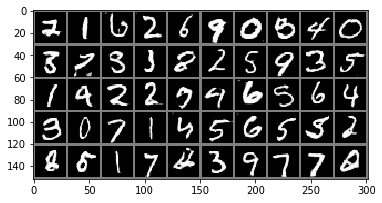

In [11]:
# Generate two random integers to select a random model that is to be used in generating a fake image batch with MarginGAN's generator
lab = np.random.randint(0,4)
ind = np.random.randint(0,5)

all_model_paths = model_paths()
model = all_model_paths[str(label_sizes[lab])][ind]
# Load the randomly selected model
marginGAN.load(model)
# Show the randomly sampled image
marginGAN.imshow(fixed_noise)

### Difficulties Encountered

Although the overall idea to utilize the GAN architecture to enhance the semi-supervised learning process was clearly explained, crucial architectural details were missing:

Firstly, since MNIST has no specific validation set, we separate 10000 samples to be used as the validation set for hyperparameter optimization. This was not mentioned in the paper.

TWe know that the paper uses 4 different number of labeled examples for their experiments. However, randomly sampling 100 images, for example, from the training set may cause a class imbalance. Therefore, to create a balanced labeled training set, we choose equal number of examples from each class. After we divided the dataset into labeled and unlabeled subsets, we observed that there were different techniques in the literature to feed the data into the model in semi-supervised learning. In various research, all labeled and unlabeled images are passed into the architecture only once per epoch. On the other hand, since the number of unlabeled images are much higher than the number of labeled images, within one iteration, some researchers prefer to iterate the labeled images in a cycle until the unlabeled images are all passed. This choice wasn’t stated in the paper. We experimented with both options and iterating the labels gave better training performance and validation results.

Classifier architecture was stated as a “6-layer” classifer but no further detail was given. The number of convolutional and fully-connected layers, the channel and kernel sizes of the layers, and the type of the activation functions were unclear. We first experimented on several architectures to satisfy the 6-layer architecture. However, increasing the number of layers by adding batch normalization following the convolutional layers improved our pretraining speed and performance (of the main architecture) remarkably. Therefore,  we set the architecture of the classifier a little bigger than it is in the paper.

Most of the hyperparameters were not specified in the paper. Since MarginGAN uses the generator and the discriminator of the InfoGAN, we experimented with the hyper-parameter settings in the utilized in InfoGAN. Furthermore, we checked popular generative model papers like DCGAN to find a good range of learning rates for our discriminator and generator. We also investigated general practices used in research, and experimented with different settings. For the learning rate value of discriminator, we tried different values and for most cases the discriminator was stable. Therefore, we choose $0.0002$ which was the setting in InfoGAN and DCGAN, both. 

Choosing the learning rate for the generator was trickier. The learning rate used in InfoGAN was 0.001 but we found that this value was too high and the images generated with this learning rate made the generator unstable. Therefore, after experimenting with lower values, we choose $0.0002$ to be the learning rate of our generator.

In the paper, they mention in Chapter 4.2 that they reduce the learning rate of the classifier from $0.1$ to $0.01$ in these experiments. We deduce that in Chapter 4.1 (where we reproduce the results) the paper uses $0.1$ learning rate for the classifier. However, after experimenting with different values of the learning rate and momentum parameter of SGD optimizer, we found that using a $0.01$ learning rate for the classifier was much more suitable along with a momentum value of $0.8$. Again, there was no mention of the momentum value that the authors used, in the paper.

We use Adam optimizer for generator and discriminator and SGD optimizer for the classifier. In MarginGAN paper, it was not mentioned which optimizer they used. However, after checking some of the popular papers, we saw that it is common to use Adam optimizer for the generator and the discriminator with $\beta_1$ value of $0.5$ and $\beta_2$ value of $0.999$. Thus, we also use these values for our experiments. 

We chose the learning rate of classifier and generator $0.01$ and $0.0002$, respectively with experimentation and hyper-parameter tuning.

